# Visualizations of Chapter 4.1.2 - Dataset Preprocessing and Data Bias Analysis

## 0) Imports

In [1]:
#!pip install 'aif360[all]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from aif360.datasets import GermanDataset

from sklearn.preprocessing import MinMaxScaler

pip install 'aif360[LawSchoolGPA]'


## 1) Pre-Processing

When initializing a built-in dataset of AIF360 the `StandardDataset` class will go through a standard preprocessing routine which:

1. (optional) Performs some dataset-specific preprocessing (e.g. renaming columns/values, handling missing data).
2. Drops unrequested columns (see features_to_keep and features_to_drop for details).
3. Drops rows with NA values.
4. Creates a one-hot encoding of the categorical variables.
5. Maps protected attributes to binary privileged/unprivileged values (1/0).
6. Maps labels to binary favorable/unfavorable labels (1/0). 
[{1.0: 'Good Credit', 2.0: 'Bad Credit'} {1.0: 'Male', 0.0: 'Female'}, {1.0: 'Old', 0.0: 'Young'}

https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.StandardDataset.html

The dataset needs a costumized preprocessing as the values of all categorical variables are originally based on an index that requires translation in order to provide human readability and normalization for numerical variables. In order to create meaningful visualizations, the numerical variables `age` and `credit_amount` are not normalized in this notebook. 

In [3]:
# Costumized Preprocessing for German Dataset
# This code is originally from: 
# https://github.com/Trusted-AI/AIF360/blob/746e763191ef46ba3ab5c601b96ce3f6dcb772fd/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py
# but extended for remaining features that were not translated by default and normalization 
def custom_preprocessing(df):
    """ Custom pre-processing for German Credit Data
    """

    def group_credit_hist(x):
        if x in ['A30', 'A31', 'A32']:
            return 'None/Paid'
        elif x == 'A33':
            return 'Delay'
        elif x == 'A34':
            return 'Critical'
        else:
            return 'NA'
        
    def group_purpose(x):
        if x in ['A40', 'A41']:
            return 'Car'
        elif x in ['A46', 'A48']:
            return 'Education'
        elif x == 'A49':
            return 'Business'
        elif x in ['A42', 'A43', 'A44','A45','A47', 'A410']:
            return 'Other'
        else:
            return 'NA'
        
    def group_property(x):
        if x == 'A121':
            return 'Real Estate'
        elif x in ['A122', 'A123']:
            return 'Other'
        elif x == 'A124':
            return 'Unknown/No Property'
        else:
            return 'NA'
        
    def group_housing(x):
        if x == 'A151':
            return 'Rent'
        elif x == 'A152':
            return 'Own'
        elif x == 'A153':
            return 'For free'
        else: 
            return 'NA'

    def group_employ(x):
        if x == 'A71':
            return 'Unemployed'
        elif x in ['A72', 'A73']:
            return '1-4 years'
        elif x in ['A74', 'A75']:
            return '4+ years'
        else:
            return 'NA'

    def group_savings(x):
        if x in ['A61', 'A62']:
            return '<500'
        elif x in ['A63', 'A64']:
            return '500+'
        elif x == 'A65':
            return 'Unknown/None'
        else:
            return 'NA'
        

    def group_status(x):
        if x in ['A11', 'A12']:
            return '<200'
        elif x in ['A13']:
            return '200+'
        elif x == 'A14':
            return 'None'
        else:
            return 'NA'

        
    def scale_min_max(feature):
        scaler = MinMaxScaler(copy=False)
        scaled_feature = scaler.fit_transform(df[feature].values[:,np.newaxis])
        return scaled_feature

    skill_level_map = {'A171': 0.0, 'A172': 0.0, 'A173': 1.0, 'A174': 1.0}
    df['skill'] = df['skill_level'].replace(skill_level_map)

    status_map = {'A91': 1.0, 'A93': 1.0, 'A94': 1.0,
                'A92': 0.0, 'A95': 0.0}
    df['sex'] = df['personal_status'].replace(status_map)


    # group credit history, purpose, savings, property, housing and employment
    df['credit_history'] = df['credit_history'].apply(lambda x: group_credit_hist(x))
    df['purpose'] = df['purpose'].apply(lambda x: group_purpose(x))
    df['savings'] = df['savings'].apply(lambda x: group_savings(x))
    df['property'] = df['property'].apply(lambda x: group_property(x))
    df['housing'] = df['housing'].apply(lambda x: group_housing(x))
    df['employment'] = df['employment'].apply(lambda x: group_employ(x))
    df['status'] = df['status'].apply(lambda x: group_status(x))
    
    # minmaxscaling for numerical features age and credit_amount
    # In order to handle the numerical features properly, we scale 'age' and 'credit_amount'
    # between 0 and 1. To do so, the MinMaxScaler is used.  
    #df['age'] = scale_min_max('age')
    #df['credit_amount'] = scale_min_max('credit_amount')
    

    return df

Initialization of the German Dataset using the costumized preprocessing function. 

In [4]:
protected_attribute = 'sex'
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
label_map = {1.0: 'Good Credit', 2.0: 'Bad Credit'}
protected_attribute_maps = [{1.0: 'Male', 0.0: 'Female'}]

dataset_preproc = GermanDataset(
    protected_attribute_names=['sex'], 
    privileged_classes = [[1.0]], #which corresponds to 'Male'
    metadata={'label_map': label_map,'protected_attribute_maps': protected_attribute_maps},
    features_to_keep=['credit_amount', 'age', 'skill', 'number_of_credits', 'sex', 'status', 'housing', 'credit_history', 'purpose', 'property', 'savings', 'employment', 'housing', 'skill_level'], 
    features_to_drop=['personal_status','other_debtors','skill_level', 'installment_plans', 'telephone','foreign_worker'],
    custom_preprocessing = custom_preprocessing
)


#index of protected attribute
protected_attribute_index = dataset_preproc.feature_names.index(protected_attribute)

#german dataset as pandas.DataFrame
dataset_df = dataset_preproc.convert_to_dataframe()[0]

#feature names and description
dataset_dict = dataset_preproc.convert_to_dataframe()[1]

print(dataset_dict)

dataset_df.head(100)



{'feature_names': ['credit_amount', 'age', 'number_of_credits', 'skill', 'sex', 'status=200+', 'status=<200', 'status=None', 'credit_history=Critical', 'credit_history=Delay', 'credit_history=None/Paid', 'purpose=Business', 'purpose=Car', 'purpose=Education', 'purpose=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed', 'property=Other', 'property=Real Estate', 'property=Unknown/No Property', 'housing=For free', 'housing=Own', 'housing=Rent'], 'label_names': ['credit'], 'protected_attribute_names': ['sex'], 'instance_names': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',

,credit_amount,age,number_of_credits,skill,sex,status=200+,status=<200,status=None,credit_history=Critical,credit_history=Delay,...,employment=1-4 years,employment=4+ years,employment=Unemployed,property=Other,property=Real Estate,property=Unknown/No Property,housing=For free,housing=Own,housing=Rent,credit
0,1169.0,67.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,5951.0,22.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
2,2096.0,49.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,7882.0,45.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,4870.0,53.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15945.0,58.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0
96,2012.0,61.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
97,2622.0,34.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
98,2337.0,36.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## 2) Prepare Dataset 

In order to generate readable visualizations of the dataset, the one-hot-encoding that is preformed by default for all catgeorical variables in the standard preprocessing routine of AIF360 needs to be reversed. To do so the converted `DataFrame` dataset is transformed into a dataset with better readability. 

In [5]:
dataset_df_visual = dataset_df.copy()

dataset_df_visual['employment'] = dataset_df_visual['employment=1-4 years'].copy()

for index,row in dataset_df_visual.iterrows():
    if row['employment=1-4 years']==1:
        dataset_df_visual.loc[index, 'employment'] = '1-4 years'
    elif row['employment=4+ years']==1:
        dataset_df_visual.loc[index, 'employment']= '4+ years'
    else:
        dataset_df_visual.loc[index, 'employment']= 'Unemployed'

dataset_df_visual = dataset_df_visual.drop(['employment=1-4 years'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['employment=4+ years'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['employment=Unemployed'], axis = 1)

dataset_df_visual['savings'] = dataset_df_visual['savings=<500'].copy()

for index,row in dataset_df_visual.iterrows():
    if row['savings=500+']==1:
        dataset_df_visual.loc[index, 'savings'] = '<500 DM'
    elif row['savings=<500']==1:
        dataset_df_visual.loc[index, 'savings']= '>=500'
    else:
        dataset_df_visual.loc[index, 'savings']= 'Unknown/None'

dataset_df_visual = dataset_df_visual.drop(['savings=Unknown/None'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['savings=500+'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['savings=<500'], axis = 1)

dataset_df_visual['credit_history'] = dataset_df_visual['credit_history=Delay'].copy()

for index,row in dataset_df_visual.iterrows():
    if row['credit_history=Critical']==1:
        dataset_df_visual.loc[index, 'credit_history'] = 'Critical'
    elif row['credit_history=Delay']==1:
        dataset_df_visual.loc[index, 'credit_history']= 'Delay'
    else:
        dataset_df_visual.loc[index, 'credit_history']= 'None/Paid'

dataset_df_visual = dataset_df_visual.drop(['credit_history=Critical'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['credit_history=Delay'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['credit_history=None/Paid'], axis = 1)

dataset_df_visual['property'] = dataset_df_visual['property=Other'].copy()

for index,row in dataset_df_visual.iterrows():
    if row['property=Other']==1:
        dataset_df_visual.loc[index, 'property'] = 'Other'
    elif row['property=Real Estate']==1:
        dataset_df_visual.loc[index, 'property']= 'Real Estate'
    else:
        dataset_df_visual.loc[index, 'property']= 'Unknown/No Property'

dataset_df_visual = dataset_df_visual.drop(['property=Unknown/No Property'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['property=Real Estate'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['property=Other'], axis = 1)

dataset_df_visual['status'] = dataset_df_visual['status=200+'].copy()

for index,row in dataset_df_visual.iterrows():
    if row['status=200+']==1:
        dataset_df_visual.loc[index, 'status'] = '200+'
    elif row['status=<200']==1:
        dataset_df_visual.loc[index, 'status']= '<200'
    else:
        dataset_df_visual.loc[index, 'status']= 'None'

dataset_df_visual = dataset_df_visual.drop(['status=200+'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['status=<200'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['status=None'], axis = 1)

dataset_df_visual['purpose'] = dataset_df_visual['purpose=Business'].copy()

for index,row in dataset_df_visual.iterrows():
    if row['purpose=Business']==1:
        dataset_df_visual.loc[index, 'purpose'] = 'Business'
    elif row['purpose=Car']==1:
        dataset_df_visual.loc[index, 'purpose']= 'Car'
    elif row['purpose=Education']==1:
        dataset_df_visual.loc[index, 'purpose']= 'Education'
    else:
        dataset_df_visual.loc[index, 'purpose']= 'Other'

dataset_df_visual = dataset_df_visual.drop(['purpose=Business'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['purpose=Car'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['purpose=Education'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['purpose=Other'], axis = 1)

dataset_df_visual['housing'] = dataset_df_visual['housing=Own'].copy()

for index,row in dataset_df_visual.iterrows():
    if row['housing=Own']==1:
        dataset_df_visual.loc[index, 'housing'] = 'Own'
    elif row['housing=For free']==1:
        dataset_df_visual.loc[index, 'housing']= 'For Free'
    else:
        dataset_df_visual.loc[index, 'housing']= 'Rent'


dataset_df_visual = dataset_df_visual.drop(['housing=Own'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['housing=For free'], axis = 1)
dataset_df_visual = dataset_df_visual.drop(['housing=Rent'], axis = 1)

dataset_df_visual['sex'] = dataset_df_visual['sex'].replace({1.0: 'male', 0.0: 'female'})
dataset_df_visual['credit'] = dataset_df_visual['credit'].replace({1.0: 'good', 2.0: 'bad'})
dataset_df_visual['skill'] = dataset_df_visual['skill'].replace({1.0: 'skilled', 0.0: 'unskilled'})
#dataset_df_visual['age'] = dataset_df_visual['age'].apply(lambda x: np.float(x >= 26)) # see Kamiran und Calders
#dataset_df_visual['age'] = dataset_df_visual['age'].replace({1.0: 'Aged', 0.0: 'Young'})

last_column = dataset_df_visual.pop('credit')
dataset_df_visual.insert(dataset_df_visual.shape[1], 'credit', last_column)



dataset_df_visual.head(100)
    


,credit_amount,age,number_of_credits,skill,sex,employment,savings,credit_history,property,status,purpose,housing,credit
0,1169.0,67.0,2.0,skilled,male,4+ years,Unknown/None,Critical,Real Estate,<200,Other,Own,good
1,5951.0,22.0,1.0,skilled,female,1-4 years,>=500,None/Paid,Real Estate,<200,Other,Own,bad
2,2096.0,49.0,1.0,unskilled,male,4+ years,>=500,Critical,Real Estate,None,Education,Own,good
3,7882.0,45.0,1.0,skilled,male,4+ years,>=500,None/Paid,Other,<200,Other,For Free,good
4,4870.0,53.0,2.0,skilled,male,1-4 years,>=500,Delay,Unknown/No Property,<200,Car,For Free,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15945.0,58.0,1.0,skilled,male,1-4 years,>=500,None/Paid,Unknown/No Property,<200,Business,Rent,bad
96,2012.0,61.0,1.0,skilled,female,4+ years,Unknown/None,Critical,Other,None,Education,Own,good
97,2622.0,34.0,1.0,skilled,male,1-4 years,>=500,None/Paid,Other,<200,Business,Own,good
98,2337.0,36.0,1.0,skilled,male,4+ years,>=500,Critical,Real Estate,<200,Other,Own,good


## 3) Visualizations 

Frequency counts of favorable and unfavorable label: 700 instances with Good Credit Risk, 300 instances with Bad Credit Risk.

In [6]:
dataset_df['credit'].value_counts(normalize=True)

credit
1.0    0.7
2.0    0.3
Name: proportion, dtype: float64

Frequency counts of males and females in the dataset: 690 Males and 310 Females.

In [7]:
dataset_df['sex'].value_counts(normalize=True)

sex
1.0    0.69
0.0    0.31
Name: proportion, dtype: float64

Code for Figure 4.1: Comparison of males and females with good and bad credit risk. Representing the groups FP, FN, DP and DN according to Kamiran and Calders (2012) when considering `sex` as protected attribute with the privileged attribute value `Male` and unprivileged attribute value `Female` and `credit` as the target variable with the favorable label `Good Credit` and unfavorable label `Bad Credit`.

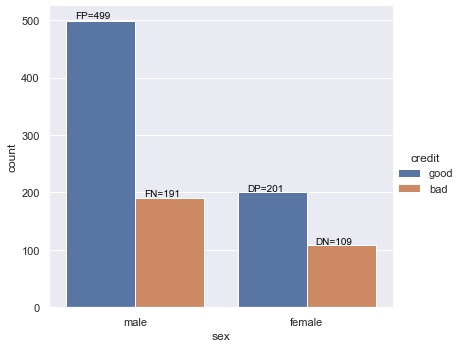

In [8]:
sns.set(font_scale=1)

plot_groups = sns.catplot(x="gender",

                hue="credit",

                data=dataset_df_visual, kind="count",

                height=4.75, aspect=1.15)

axis = plot_groups.facet_axis(0,0)

i=0
for patch in axis.patches:
    if i == 0:
        axis.text(patch.get_x() + 0.05, 
                patch.get_height() * 1.01, 
               'FP={}'.format(patch.get_height()),  
                color='black', 
                rotation='horizontal')
    elif i == 1:
        axis.text(patch.get_x() + 0.05, 
                patch.get_height() * 1.01, 
               'DP={}'.format(patch.get_height()),  
                color='black', 
                rotation='horizontal')
    elif i == 2:
        axis.text(patch.get_x() + 0.05, 
                patch.get_height() * 1.01, 
               'FN={}'.format(patch.get_height()),  
                color='black', 
                rotation='horizontal')
    else:
        axis.text(patch.get_x() + 0.05, 
                patch.get_height() * 1.01, 
               'DN={}'.format(patch.get_height()),  
                color='black', 
                rotation='horizontal')
    i=i+1
        

#plt.legend(bbox_to_anchor=(1.05, 0.65), loc=2, borderaxespad=0.)
 
# Show the plot
plt.show()

# Save the plot 
#plot_groups.savefig('plots/plot_group.png') 

Code for Figure 4.2: Distribution of the numerical attribute `age` given the target attribute `credit` and boxplot chart of the numerical attribute `credit_amount` by `sex` given the target attribute `credit`.

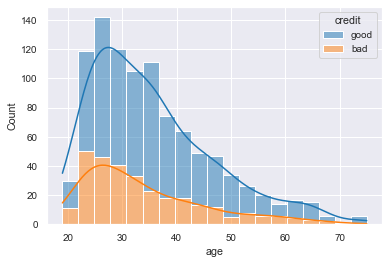

In [9]:
# a) Age distribution
sns.set(font_scale=0.9)
age_distribution = sns.histplot(data=dataset_df_visual, x='age', hue='credit', palette='tab10', multiple='stack', kde=True)
plt.show()

#fig_age = age_distribution.get_figure()
#fig_age.savefig('plots/age_distribution.png') 

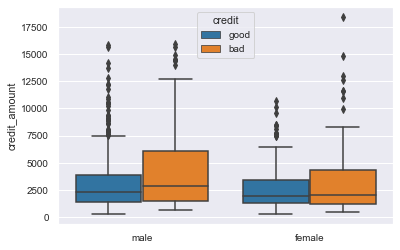

In [10]:
# b) Credit amount by sex
sns.set(font_scale=0.9)
credit_amount_plot = sns.boxplot(data=dataset_df_visual, x='sex', y='credit_amount', palette='tab10', hue='credit')
credit_amount_plot.set_xlabel("")
#plt.legend(bbox_to_anchor=(1.05, 0.65), loc=2, borderaxespad=0.)

plt.show()

#fig = credit_amount_plot.get_figure()
#fig.savefig('plots/credit_amount_gender.png') 

Code for Figure 4.3: Comparison of credit risks between males and females given the categorical variables `employment` and `credit_history`

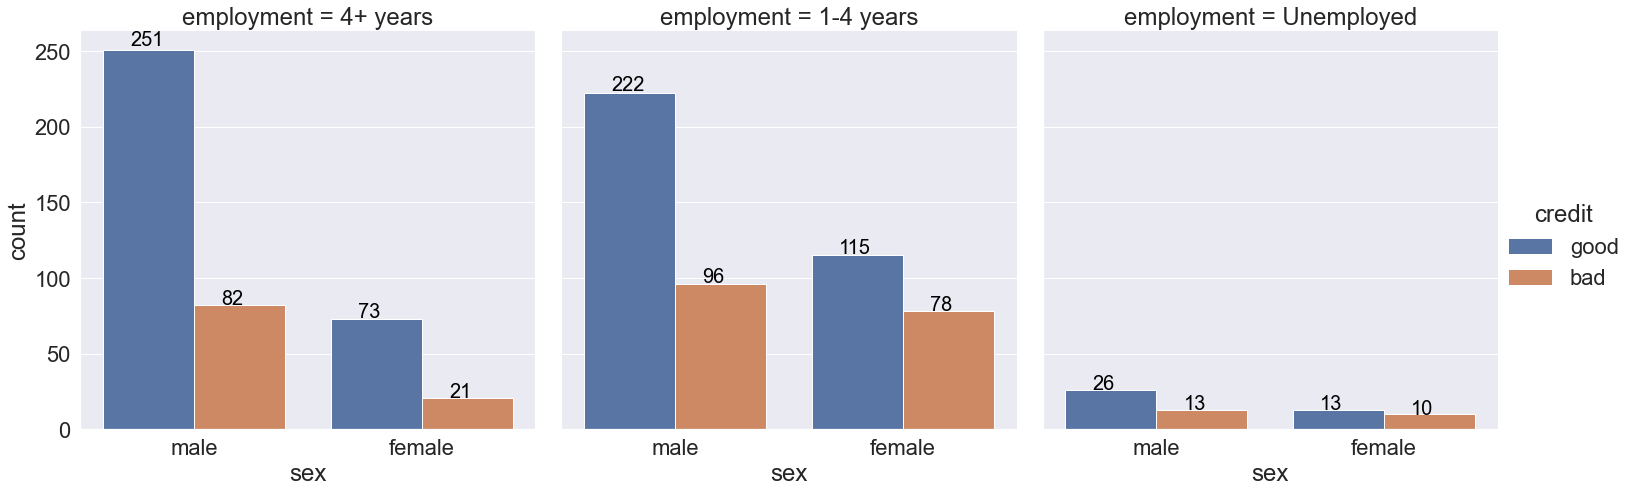

In [11]:
# a) Number of males and females classified by good and bad credit risks for the categorical attribute employment
sns.set(font_scale=2)
plot_employment = sns.catplot(x="sex",

                hue="credit", col="employment",

                data=dataset_df_visual, kind="count",

                height=7, aspect=1)

for axis in plot_employment.axes.ravel():
    for patch in axis.patches:
        axis.text(patch.get_x() + 0.12, 
                patch.get_height() * 1.01, 
               '{}'.format(patch.get_height()),  
                color='black', 
                rotation='horizontal', 
                size='small')
        
#plt.legend(bbox_to_anchor=(1.05, 0.65), loc=2, borderaxespad=0.)


#plot_employment.savefig('plots/employment_count_plot.png') 
plt.show()

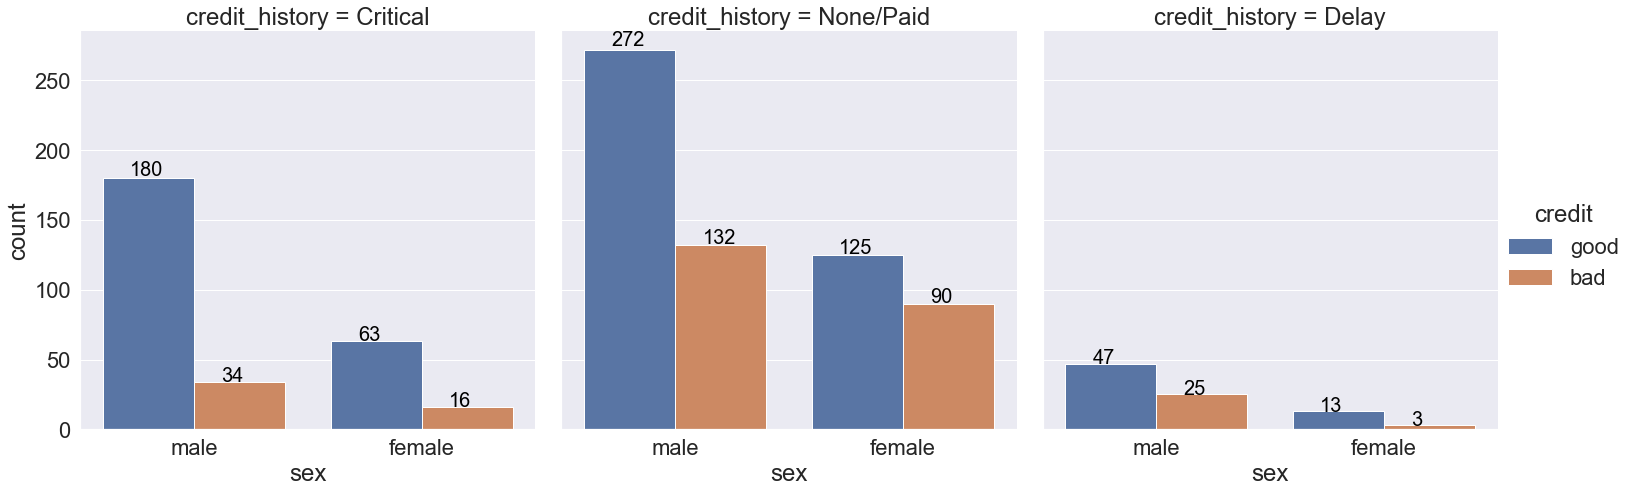

In [12]:
# b) Number of males and females classified by good and bad credit risks for the categorical attribute credit_history
sns.set(font_scale=2)
plot_credit_history = sns.catplot(x="sex",

                hue="credit", col="credit_history",

                data=dataset_df_visual, kind="count",

                height=7, aspect=1)

for axis in plot_credit_history.axes.ravel():
    for patch in axis.patches:
        axis.text(patch.get_x() + 0.12, 
                patch.get_height() * 1.01, 
               '{}'.format(patch.get_height()),  
                color='black', 
                rotation='horizontal', 
                size='small')

#plot_credit_history.savefig('plots/credit_history_count_plot.png') 
plt.show()